
# ==========================================
# IMPORT LIBRARY & CONNECT DB
# ==========================================


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, silhouette_score 
import warnings
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

print("Library siap")

Library siap



# ==========================================
# BUSINESS UNDERSTANDING
# ==========================================


In [5]:
print("\n[1.1] Determine Business Objectives:")
print("   - Meningkatkan profitabilitas dengan memahami perilaku pelanggan.")
print("   - Mengidentifikasi tren penjualan untuk manajemen stok.")

print("\n[1.2] Assess Situation:")
print("   - Data tersedia dalam format SQL Dump (Star Schema).")
print("   - Tools: Python (Pandas, Scikit-learn).")
print("   - Resources: Data historis transaksi penjualan.")

print("\n[1.3] Determine Data Mining Objectives:")
print("   - Melakukan Customer Segmentation (Clustering).")
print("   - Melakukan Sales Forecasting (Regression).")

print("\n[1.4] Produce Project Plan:")
print("   - Timeline: Load Data -> Clean -> Model -> Evaluate -> Deploy.")
print("   - Success Criteria: Segmentasi yang jelas & Error forecasting rendah.")


[1.1] Determine Business Objectives:
   - Meningkatkan profitabilitas dengan memahami perilaku pelanggan.
   - Mengidentifikasi tren penjualan untuk manajemen stok.

[1.2] Assess Situation:
   - Data tersedia dalam format SQL Dump (Star Schema).
   - Tools: Python (Pandas, Scikit-learn).
   - Resources: Data historis transaksi penjualan.

[1.3] Determine Data Mining Objectives:
   - Melakukan Customer Segmentation (Clustering).
   - Melakukan Sales Forecasting (Regression).

[1.4] Produce Project Plan:
   - Timeline: Load Data -> Clean -> Model -> Evaluate -> Deploy.
   - Success Criteria: Segmentasi yang jelas & Error forecasting rendah.


# ==========================================
#  BLOK 2: DATA UNDERSTANDING
# ==========================================

[2.1] Loading Data from SQL...
[2.2] Exploring Data Structure...
   -> Total Rows: 1000
   -> Columns: ['sk_date', 'sk_customer', 'sk_product', 'sk_store', 'final_qty', 'final_amount', 'total_orders', 'fact_id', 'Customer ID', 'Age', 'Gender', 'Product Category', 'technical', 'Date', 'Year', 'Month', 'Day', 'Quarter', 'smart_key']

[2.3] Visualizing Anomalies & Distribution (Early Check)...


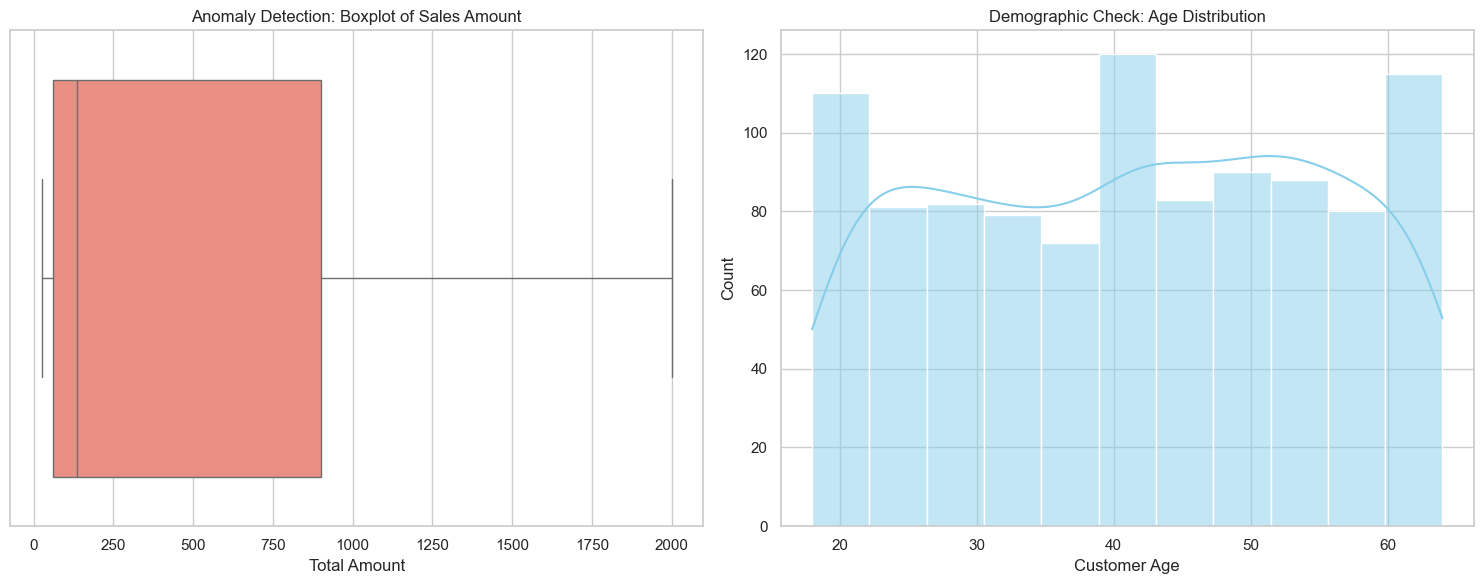

   -> Diagram Anomali (Boxplot) & Distribusi Ditampilkan.


In [6]:

def parse_sql_inserts(file_path, table_name, columns):
    try:
        with open(file_path, 'r', encoding='utf-8') as f: content = f.read()
    except:
        with open(file_path, 'r', encoding='latin-1') as f: content = f.read()
    
    pattern = re.compile(f"INSERT INTO `{table_name}` \((.*?)\) VALUES\s*(.*?;)", re.DOTALL)
    match = pattern.search(content)
    if not match: return pd.DataFrame(columns=columns)
    
    values_str = match.group(2).strip().rstrip(';')
    rows = re.split(r'\),\s*\(', values_str)
    data = []
    for row in rows:
        row = row.lstrip('(').rstrip(')')
        try:
            data.append(eval(f"({row})"))
        except: pass
    return pd.DataFrame(data, columns=columns)

print("[2.1] Loading Data from SQL...")
cols_fact = ['sk_date', 'sk_customer', 'sk_product', 'sk_store', 'final_qty', 'final_amount', 'total_orders', 'fact_id']
cols_cust = ['sk_customer', 'Customer ID', 'Age', 'Gender']
cols_prod = ['sk_product', 'Product Category']
cols_date = ['technical', 'Date', 'Year', 'Month', 'Day', 'Quarter', 'smart_key']

df_fact = parse_sql_inserts('tubes_dwbi.sql', 'fact_sales', cols_fact)
df_cust = parse_sql_inserts('tubes_dwbi.sql', 'dim_customer', cols_cust)
df_prod = parse_sql_inserts('tubes_dwbi.sql', 'dim_product', cols_prod)
df_date = parse_sql_inserts('tubes_dwbi.sql', 'dim_date', cols_date)

print("[2.2] Exploring Data Structure...")
df = df_fact.merge(df_cust, on='sk_customer', how='left')
df = df.merge(df_prod, on='sk_product', how='left')
df = df.merge(df_date, left_on='sk_date', right_on='smart_key', how='left')
df['Date'] = pd.to_datetime(df['Date'])
print(f"   -> Total Rows: {len(df)}")
print(f"   -> Columns: {list(df.columns)}")

print("\n[2.3] Visualizing Anomalies & Distribution (Early Check)...")
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['final_amount'], color='salmon')
plt.title('Anomaly Detection: Boxplot of Sales Amount')
plt.xlabel('Total Amount')

plt.subplot(1, 2, 2)
sns.histplot(df['Age'], kde=True, color='skyblue')
plt.title('Demographic Check: Age Distribution')
plt.xlabel('Customer Age')

plt.tight_layout()
plt.show()
print("   -> Diagram Anomali (Boxplot) & Distribusi Ditampilkan.")

# ==========================================
# BLOK 3: DATA PREPARATION
# ==========================================

In [7]:
print("[3.2] Constructing Data (Resampling to Weekly)...")

df_sorted = df.set_index('Date').sort_index()

weekly_sales = df_sorted.resample('W')['final_amount'].sum().reset_index()

weekly_sales['Time_Index'] = range(len(weekly_sales))

print(f"   -> Data dikompres dari {len(df)} transaksi jadi {len(weekly_sales)} titik data mingguan.")
print("   -> Grafik bakal lebih smooth (anti-spike).")

cust_agg = df.groupby('Customer ID').agg({
    'final_amount': 'sum',
    'fact_id': 'count'
}).reset_index()
cust_agg.columns = ['Customer_ID', 'Monetary', 'Frequency']

[3.2] Constructing Data (Resampling to Weekly)...
   -> Data dikompres dari 1000 transaksi jadi 54 titik data mingguan.
   -> Grafik bakal lebih smooth (anti-spike).


# ==========================================
# BLOK 4: MODELING
# ==========================================

In [9]:
# 4.1 Clustering (Tetep sama)
print("[4.1] Building K-Means Model...")
scaler = StandardScaler()
X_cluster = scaler.fit_transform(cust_agg[['Monetary', 'Frequency']])
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cust_agg['Cluster'] = kmeans.fit_predict(X_cluster)

# 4.2 Forecasting (Ganti pake Weekly Data)
print("[4.2] Building Regression Model (Weekly Trend)...")
reg = LinearRegression()
X_reg = weekly_sales[['Time_Index']]
y_reg = weekly_sales['final_amount']
reg.fit(X_reg, y_reg)
print(f"   -> Model Slope: {reg.coef_[0]:.4f}")

# Predict Next 4 Weeks (Sebulan ke depan)
last_idx = weekly_sales['Time_Index'].max()
future_X = np.array(range(last_idx + 1, last_idx + 5)).reshape(-1, 1) # Prediksi 4 minggu
future_vals = reg.predict(future_X)

# Bikin tanggal masa depan (per minggu)
last_date = weekly_sales['Date'].max()
future_dates = [last_date + pd.Timedelta(weeks=i) for i in range(1, 5)]

future_df = pd.DataFrame({'Date': future_dates, 'final_amount': future_vals, 'Type': 'Forecast'})
weekly_sales['Type'] = 'Actual'
combined = pd.concat([weekly_sales[['Date', 'final_amount', 'Type']], future_df])

[4.1] Building K-Means Model...
[4.2] Building Regression Model (Weekly Trend)...
   -> Model Slope: 3.8654


# ==========================================
# BLOK 5: EVALUATION
# ==========================================

[5.3] Displaying Final Smoothed Charts...


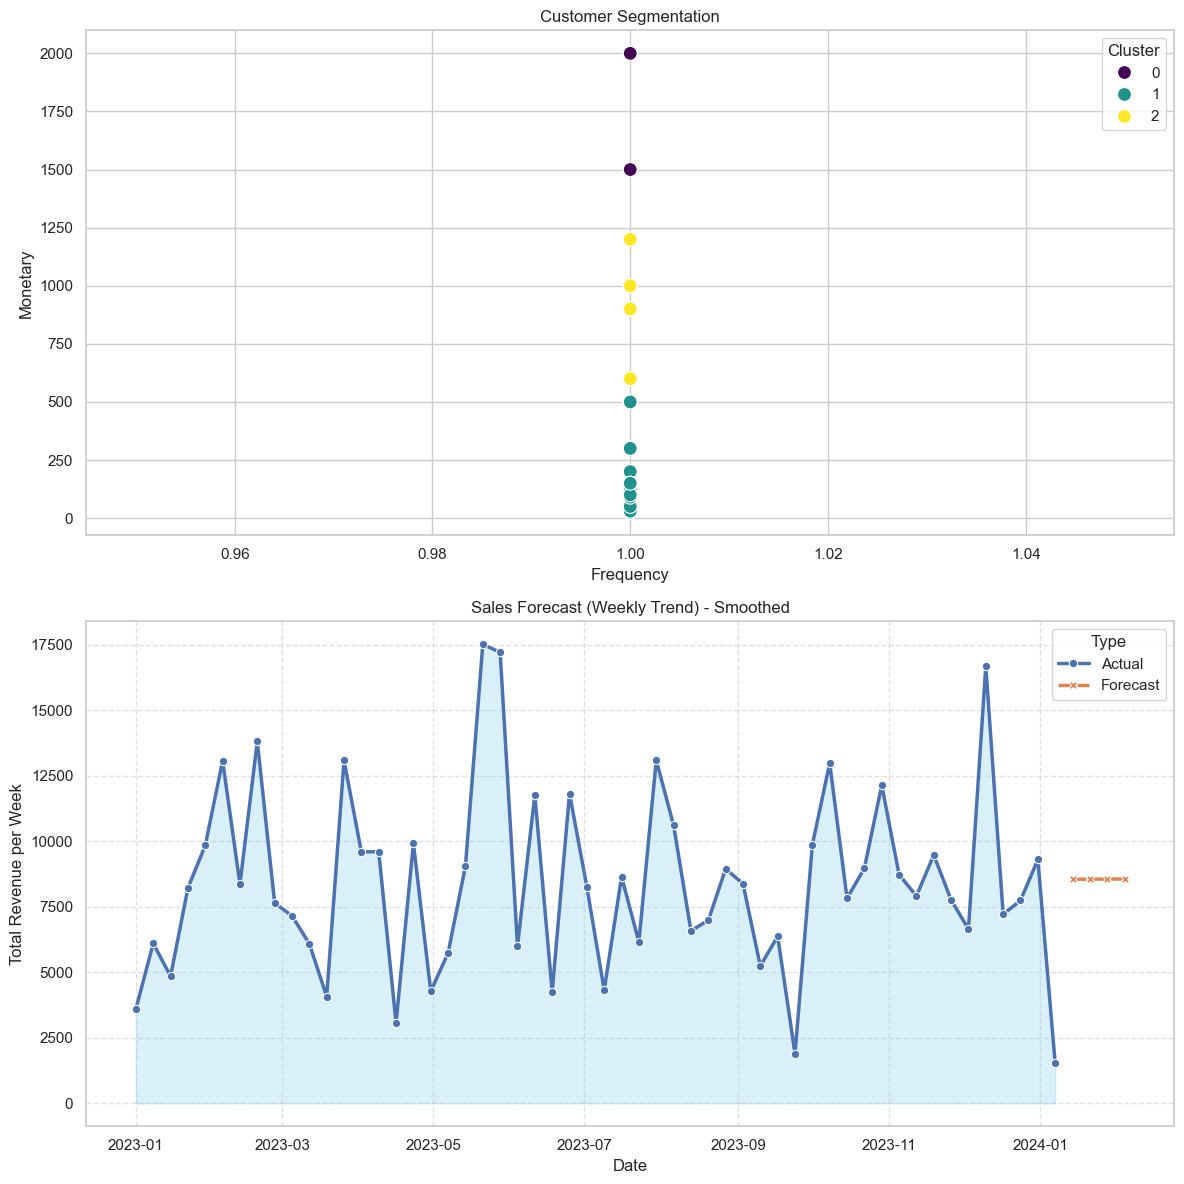

In [10]:
print("[5.3] Displaying Final Smoothed Charts...")
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# 1. Cluster Viz
sns.scatterplot(data=cust_agg, x='Frequency', y='Monetary', hue='Cluster', palette='viridis', s=100, ax=axes[0])
axes[0].set_title('Customer Segmentation')

# 2. Forecast Viz (YANG INI JADI LEBIH RAPI)
# Kita pake marker 'o' biar titik minggunya kelihatan
sns.lineplot(data=combined, x='Date', y='final_amount', hue='Type', style='Type', markers=True, ax=axes[1], linewidth=2.5)

# Tambahin area fill biar makin ganteng kayak dashboard saham
axes[1].fill_between(weekly_sales['Date'], weekly_sales['final_amount'], alpha=0.3, color='skyblue')

axes[1].set_title('Sales Forecast (Weekly Trend) - Smoothed')
axes[1].set_ylabel('Total Revenue per Week')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()